# Methods for differentiating experimental data

The goal of this notebook is to gather common methods for differentiation for comparison across a suite of examples. 

References:

[1] Numerical differentiation of experimental data: local versus global methods, K. Ahnert and M. Abel 

## Load libraries

In [1]:
%matplotlib inline

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy import interpolate, fftpack, integrate

## Local methods

The classic methods, look them up in Numerical Recipes.

### Finite differences method
There's always a better choice.

In [3]:
def dydx_i_finite_differences(i, y, dx, k):
    """Compute the numerical derivative of equally-spaced y using the Taylor series.
    Returns dy[i]/dx.

    Keyword arguments:
    i -- the index at which the derivative is computed
    y -- the data
    dx -- spacing for the data y
    k -- the number of points around i to use for the derivative
    """
    if i - k < 0 or i + k > len(y) - 1:
        return np.nan

    res = []
    coefficient = 1 # combinatorial coeff. from Taylor series
    for j in range(1,k+1):
        coefficient *= (k-j+1)/(k+j)
        alpha_j = 2*np.power(-1, j+1)*coefficient
        res.append(alpha_j*(y[i+j]-y[i-j])/(2*j)/dx)
    return np.sum(res)

### Savitzky-Golay Filter method

In [4]:
def dydx_i_savitzky_golay(i, y, x, m, k_l, k_r):
    """Compute the numerical derivative by first finding the best (least-squares) polynomial of order 
    m < 2k using the points [x[i-k_l], x[i+k_r]]. Next, the derivative is computed from the coefficients
    of the polynomial. Note: data do not have to be equally spaced.
    Returns dy[i]/dx.
    TODO: issue warnings for exits 
    
        Keyword arguments:
    i -- the index at which the derivative is computed
    y -- the data y(x)
    x -- the domain
    m - m<(k_l+k_r+1) is the order of the polynomial to fit to the data
    k_l (k_r) -- the number of points to the left (right) of i to use for the fit
    """
    if len(y) != len(x):
        return np.nan
    
    if i - k_l < 0 or i + k_r > len(y) - 1:
        return np.nan
    
    X = np.array([np.power(x[(i-k_l):(i+k_r+1)], n) for n in range(m+1)]).T
    w,_,_,_ = np.linalg.lstsq(X, y[(i-k_l):(i+k_r+1)], rcond=None)
    return np.sum([j*w[j]*np.power(x[i],j-1) for j in range(1, m+1)])

## Global methods

I should include the spectral method without truncation or regularization.

For the fancier methods, the main assumption is that physical functions are smooth. Smoothness acts as a regularization term.

### B-splines
The best choice is Cubic spline. The NURBS Book seems definitive for learning more about these methods.

In [5]:
def dydx_spline(y, x, smoothing, order=3, periodic=False):
    """Compute the numerical derivative of y using a (Cubic) spline (it was asserted that
    over all Splines, the Cubic spline minimizes the curvature of the fit). Compute the 
    derivative from the form of the known Spline polynomials.

    Keyword arguments:
    y -- the data (number of values is even for now)
    x --  x-values for the data
    """
    
    # returns (knots, coefficients, order)
    spl = sp.interpolate.splrep(x, y, k=order, s=smoothing, per=periodic)
    return lambda xs: sp.interpolate.splev(xs, spl, der=1)

### Spectral methods
Spectral methods are straightforward and are implemented in scipy. A regularized spectral method is implemented.

# Examples

## Example 1: Sine

### Setup

In [6]:
def f1(x, sigma):
    '''Sine with gaussian noise.'''
    return np.sin(x) + np.random.normal(loc=0, scale=sigma, size=x.shape)

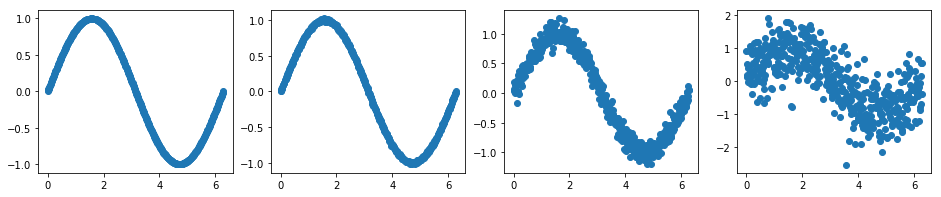

In [45]:
sigmas = [0, 0.01, 0.1, .5]
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])

x = np.linspace(0, 2*np.pi, 500)
for axs, s in zip(ax, sigmas): 
    axs.scatter(x, f1(x, s))

### Finite differences

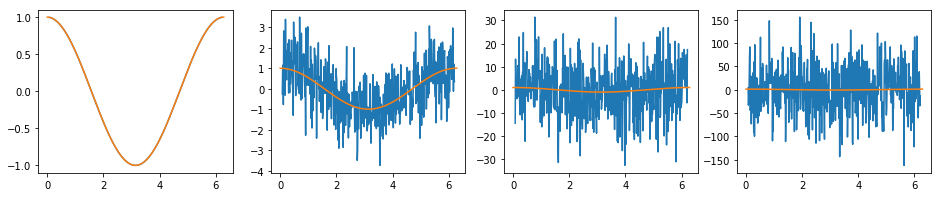

In [46]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for axs, s in zip(ax, sigmas):
    fd = [dydx_i_finite_differences(i, f1(x, s), x[1]-x[0], 6) for i in range(len(x))]
    axs.plot(x, fd)
    axs.plot(x, np.cos(x))

### Savitzky-Golay Filter
The window size is a hyper-parameter.

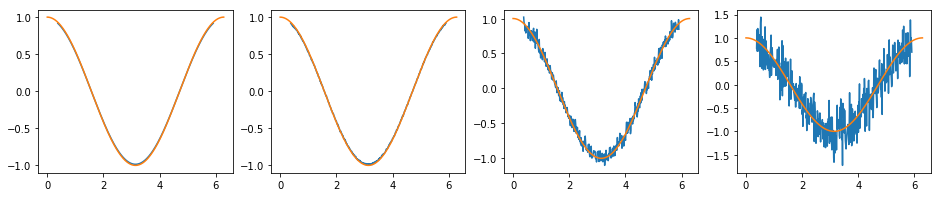

In [63]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for axs, s in zip(ax, sigmas):
    sg = [dydx_i_savitzky_golay(i, f1(x, s), x, 2, 30, 30) for i in range(len(x))]
    axs.plot(x, sg)
    axs.plot(x, np.cos(x))

### Splines
Smoothing is a hyper-parameter. The Spline functions have re-run functionality built-in so cross-validation should take advantage of this. Also, the data may benefit greatly from binning and re-weighting (weights are an available parameter--they change the definition of the loss function).

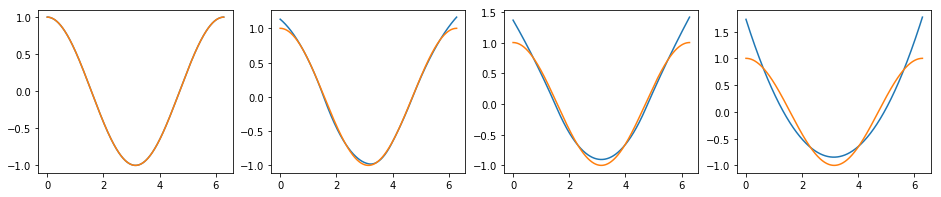

In [50]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for iax, s, ismooth in zip(ax, sigmas, [0, .085, 6, 140]):
    iax.plot(x, dydx_spline(f1(x, s), x, smoothing=ismooth)(x))
    iax.plot(x, np.cos(x))

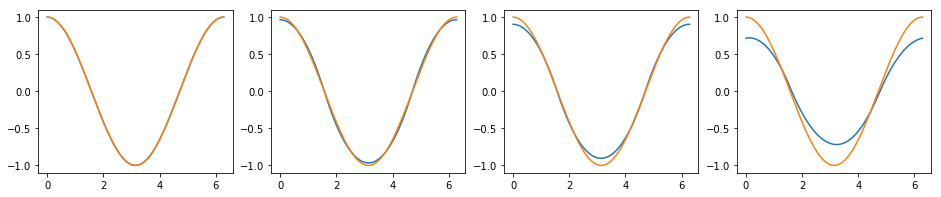

In [52]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for iax, s, ismooth in zip(ax, sigmas, [0, .085, 6, 140]):
    iax.plot(x, dydx_spline(f1(x, s), x, periodic=True, smoothing=ismooth)(x))
    iax.plot(x, np.cos(x))

### Spectral method

#### Standard (without regularization)

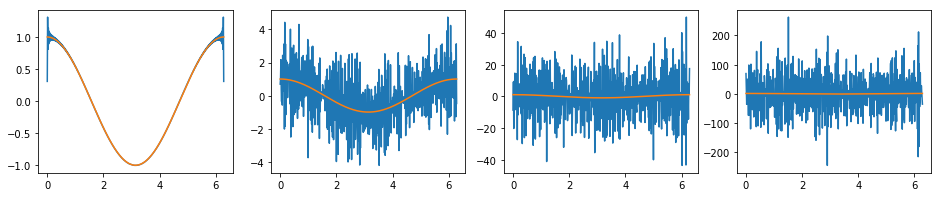

In [53]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for iax, s in zip(ax, sigmas):
    iax.plot(x, sp.fftpack.diff(f1(x,s), order=1, period=(x[-1]-x[0])))
    iax.plot(x, np.cos(x))

In [13]:
def dydx_spectral_smoothing(y, x, n, lambd):
    """Compute the numerical derivative.

    Keyword arguments:
    y -- the data (number of values is even for now)
    lambd -- hyper-parameter controlling the curvature regularization
    npts -- (even) number of coefficients in the Fourier series <= len(x)
    """  
    length = x[-1]-x[0]
    k, i = np.meshgrid(np.arange(-n//2, n//2), np.arange(len(x)))
    W = np.power(np.exp(-2j*np.pi), k*x[i]/length) # x_i by k
    
    curvature = lambd*(2*np.pi/length)**4*np.array([fk**4 for fk in range(-n//2, n//2)])
    
    ck = np.linalg.solve((W.T@np.conj(W) + curvature), W.T@y)
    
    # Not ideal return, but this will do for now
    return lambda x0: np.sum([(2j*np.pi*fk/length)*ck[i]*np.exp(2j*np.pi**fk*x0/length)
                              for i, fk in enumerate(range(-n//2, n//2))])

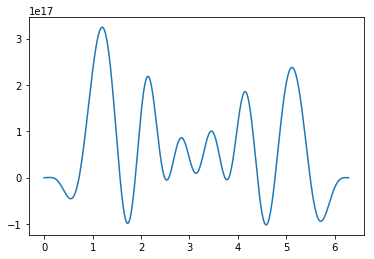

In [38]:
y = f1(x, 0)
n = 20
lambd = 0

length = x[-1]-x[0]
k, i = np.meshgrid(np.arange(-n//2, n//2), np.arange(len(x)))
W = np.power(np.exp(-2j*np.pi), k*x[i]/length)/np.sqrt(len(x)) # x_i by k

curvature = lambd*(2*np.pi/length)**4*np.array([fk**4 for fk in range(-n//2, n//2)])

ck = np.linalg.solve((W.T@np.conj(W) + curvature), W.T@y)

plt.plot(x, [np.sum([ck[i]*np.exp(2j*np.pi*fk*xi/length)
                     for i, fk in enumerate(range(-n//2, n//2))]).real for xi in x])

In [16]:
ck_f = 
plt.plot([np.sum([ck[i]*np.exp(2j*np.pi*fk*xi/length)
                  for i, fk in enumerate(range(-n//2, n//2))]) for xi in x])

SyntaxError: invalid syntax (<ipython-input-16-ae70d8609bfc>, line 1)

In [ ]:
ck_m = (W.T@y)
plt.plot(x, [np.sum([ck_m[i]*np.exp(2j*np.pi*fk*xi/length)
                  for i, fk in enumerate(range(-n//2, n//2))])/n for xi in x])

In [ ]:
res = dydx_spectral_smoothing(f1(x,0), x, len(x), 0)
plt.plot(x, [res(xi).real for xi in x])

In [ ]:
def dydx_spectral_filtered(y, x, m, lambd):
    """Compute the numerical derivative of equally-spaced y using the spectral method [1].
    This implementation seeks the optimal cutoff value k0 of the Butterworth filter:
        B(k,k0;m) = 1/(1+(k/k0)^(2m))
    for a loss function:
        |y-f(x)|_2^2 + lambd*curvature(f(x)) 
    where:
        f(x) = IFT(Butterworth(k,k0;m)*f_ft(k)) with f_ft(k)=FT(f(x)).

    Keyword arguments:
    y -- the data (number of values is even for now)
    x -- equally-spaced x-values for the data
    m -- hyper-parameter controlling the steepness of Butterworth cutoff (typically between 6 and 10)
    lambd -- hyper-parameter controlling the curvature regularization 
    """
    y_ft = np.fft.fft(y)
    
    # Solve eqn for optimal k0
    
    dydx_est = np.fft.ifft([1j*k*y_ft[k]/(1+np.power(k/k0, 2*m)) for k in range(len(y_ft))])

Note that reordering the Fourier coefficients is important. I'm still unsure why this isn't implicitely taken care of within the exponential, but the idea is that the second set of frequencies loop around with a full 2$\pi$ such that the direction looks negative as x is increased.

In [ ]:
fig, ax = plt.subplots(2,2)

# An example of correct (and logically consistent) ways to do idft.
ck = np.fft.fftshift(np.fft.fft(f1(x,0)))
res = np.array([np.sum(ck*np.exp(1j*x[i]*np.arange(-len(ck)//2, len(ck)//2)))/len(ck) for i in range(len(x))])
ax[0,0].plot(x, np.real(res))

ax[0,1].plot(x, np.real(np.fft.ifft(np.fft.fft(f1(x,0)))))

# The naive (incorrect) way only captures 1/2 of the coeff's
ck = np.fft.fft(f1(x,0))
res2_1 = np.array([np.sum(ck[:len(ck)//2]*np.exp(1j*x[i]*np.arange(0, len(ck)//2)))/len(ck) for i in range(len(x))])
ax[1,0].plot(x, np.real(res2_1))

res2_2 = np.array([np.sum(ck[len(ck)//2:]*np.exp(1j*x[i]*np.arange(len(ck)//2, len(ck))))/len(ck) for i in range(len(x))])
ax[1,0].plot(x, np.real(res2_2))

# The correct frequencies use [-N/2,0) instead of [N/2,N). I have no idea why.
res2_i = np.array([np.sum(ck*np.exp(1j*x[i]*len(ck)*np.fft.fftfreq(len(ck))))/len(ck) for i in range(len(x))])
ax[1,1].plot(x, np.real(res2_i))

## Example 2: Lorenz system
Inspect the differentiation of the x-component of the Lorenz oscillator.

### Setup

In [361]:
class lorenz:
    '''Simulate the Lorenz system:
        x'=sigma(y-x)
        y'=Rx-y-xz
        z'=-bz+xy
    '''
    def __init__(self, sigma, R, b, noise=0):
        self.t = np.array([])
        self.x = np.array([])
        self.sigma,self.R,self.b = sigma,R,b
        self.noise = noise
    def f(self, t, x):
        x1,x2,x3 = x
        return [self.sigma*(x2-x1), self.R*x1-x2-x1*x3, -self.b*x3+x1*x2]
    def simulate(self, t0, x0, t_bound, max_step=np.inf):
        self.solver = sp.integrate.RK45(self.f, t0, x0, t_bound, max_step=max_step)
        if self.t.size > 0:
            self.t = np.hstack((self.t, t0))
        else:
            self.t = t0
        if self.x.size > 0:
            self.x = np.hstack((self.x, x0))
        else:
            self.x = x0
        for i in range(1, t_bound):
            self.solver.step()
            self.t = np.hstack((self.t, self.solver.t))
            self.x = np.vstack((self.x, self.solver.y)) + np.random.normal(scale=self.noise)

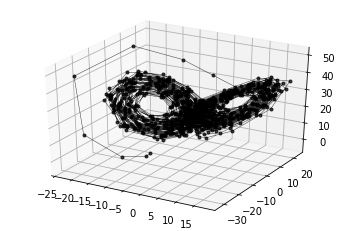

In [362]:
l = lorenz(10, 28, 8/3)
l.simulate(0, -20*np.random.rand(3), 1000)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(l.x[:,0], l.x[:,1], l.x[:,2], color='k', marker='.', lw=0.5, alpha=0.75)

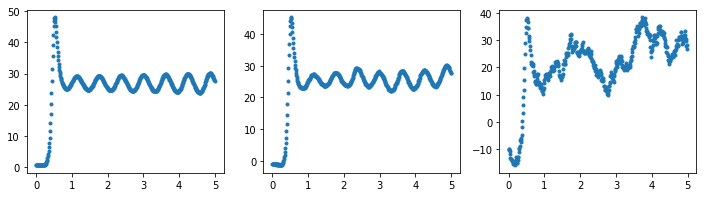

In [411]:
x0 = 2*np.random.rand(3)-1
sigmas = [0, .1, 1]

fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
lorenz_list = []
for axs, s in zip(ax, sigmas):
    l = lorenz(10, 28, 8/3, s)
    l.simulate(0, x0, 500, 0.01)
    lorenz_list.append(l)
    axs.scatter(l.t, l.x[:,i], marker='.')

### Finite differences

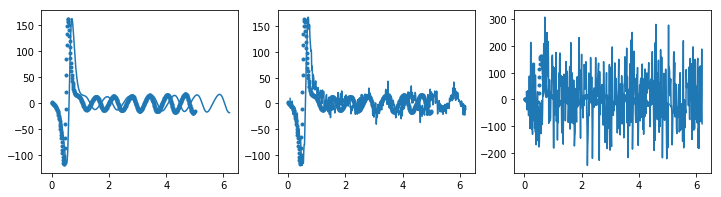

In [412]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for i, s in enumerate(sigmas):
    l = lorenz_list[i]
    fd = [dydx_i_finite_differences(i, l.x[:,0], l.t[1]-l.t[0], 6) for i in range(len(l.t))]
    ax[i].plot(x, fd)
    ax[i].scatter(l.t[1:], l.sigma*(l.x[:-1,1]-l.x[:-1,0]), marker='.')

### Savitzky-Golay Filter

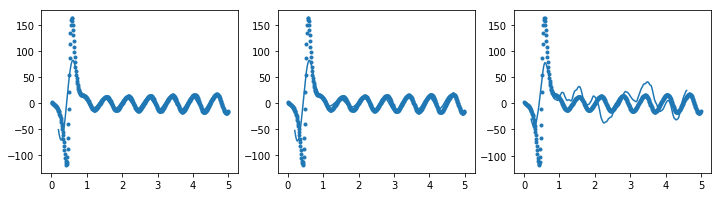

In [413]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for i, s in enumerate(sigmas):
    l = lorenz_list[i]
    sg = [dydx_i_savitzky_golay(i, l.x[:,0], l.t, 3, 20, 40) for i in range(len(l.t))]
    ax[i].plot(l.t, sg)
    ax[i].scatter(l.t[1:], l.sigma*(l.x[:-1,1]-l.x[:-1,0]), marker='.')

### Splines

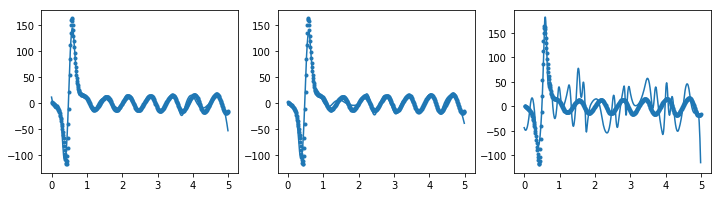

In [416]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for iax, l, s, sm in zip(ax, lorenz_list, sigmas, [60, 60, 600]):
    iax.plot(l.t, dydx_spline(l.x[:,0], l.t, smoothing=sm)(l.t))
    iax.scatter(l.t[1:], l.sigma*(l.x[:-1,1]-l.x[:-1,0]), marker='.')

### Spectral method

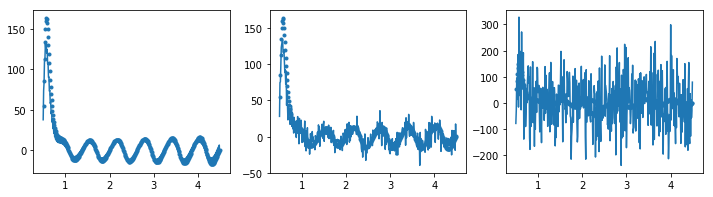

In [415]:
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
for i, s in enumerate(sigmas):
    l = lorenz_list[i]
    # Truncate ends by 10%
    trunc = int(0.1*len(l.t))
    ax[i].plot(l.t[trunc:-trunc], sp.fftpack.diff(l.x[:,0], order=1)[trunc:-trunc])
    ax[i].scatter(l.t[trunc+1:-trunc], l.sigma*(l.x[trunc:-trunc-1,1]-l.x[trunc:-trunc-1,0]), marker='.')